#Critique of Methodology
##By Ryan Barnes

First of all, I do have some problems with how the statistics were done. That's not to say that what Erik Fisher did is not important. I mean c'mon, I wouldn't even be talking about this if he didn't do his thing. My thing is that I think I have found some flaws in the way that he did things. I'll do a more thourough post-mortem on my blog that will highlight other critiques on the methodology, but I just wanted to highlight the main trap that I think Eric walked into. I've done it myself, and I learned from that experience. Hopefully, if you read through this notebook you will see the trap and how to avoid it too.

In [2]:
import pandas
from statsmodels.tsa.stattools import *
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
%matplotlib inline

Let's just start with a simple monte carlo experiment to see what can go wrong. Notice that b is not dependent on a at all. Yet both variables depend on time. We'll set up to regress a on b and not worry about time. According to our true relationship, the coefficient on "a" should be zero. Let's see what happens.

In [7]:
a=[]
b=[]
np.random.seed(8184)
for t in range(1000):
    a.append(0.5*t+np.random.normal(0,1))
    b.append(13*t+np.random.normal(0,1))
df=pandas.DataFrame([a,b]).T
df.columns=['a','b']
df['const']=1
X=df[['a','const']]
sm.OLS(df['b'],X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      b   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.279e+07
Date:                Fri, 20 May 2016   Prob (F-statistic):               0.00
Time:                        06:37:27   Log-Likelihood:                -4631.1
No. Observations:                1000   AIC:                             9266.
Df Residuals:                     998   BIC:                             9276.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
a             26.0033      0.005   4773.821      0.000        25.993    26.014
const          0.1831      1.571      0.117      0.907        -2.900     3.266
==============================================================================
Omnibus:                        1.339   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.512   Jarque-Bera (JB):                1.319
Skew:                           0.008   Prob(JB):                        0.517
Kurtosis:                       2.823   Cond. No.                         576.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Holy cow, a explains b perfectly, R2=1! And look at that t-statistic 4773.821! highly significant. "a" predicts "b" I am the best! Oh wait it should have been zero, what happened? Okay so most of you probably saw where I was going with this before I ran the regression. "a" correlates to "b" indirectly through time, essentially that's saying "a" is correlated with stuff in the error term. So let's see where we went wrong. The problem is that we have non-stationary time series. Let's see that, and then correct for it, and see if we can get the right answer that "a" has no effect on "b".

In [14]:
print adfuller(df['a'],regression='ct')
print adfuller(df['b'],regression='ct')
df['a_']=df['a'].diff(1)
df['b_']=df['b'].diff(1)
X=df[['a_','const']].dropna()
sm.OLS(df['b_'].dropna(),X).fit().summary()

(-31.252546298986747, 0.0, 0L, 999L, {'5%': -3.4148938944043334, '1%': -3.9678607816618312, '10%': -3.1296421434972537}, 2696.2448334868395)
(-19.518037053814297, 0.0, 2L, 997L, {'5%': -3.4149027470782776, '1%': -3.9678790757313824, '10%': -3.1296473513794565}, 2840.7842530489115)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     b_   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6291
Date:                Fri, 20 May 2016   Prob (F-statistic):              0.428
Time:                        06:51:51   Log-Likelihood:                -1791.6
No. Observations:                 999   AIC:                             3587.
Df Residuals:                     997   BIC:                             3597.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
a_             0.0272      0.034      0.793      0.428        -0.040     0.094
const         12.9863      0.049    264.293      0.000        12.890    13.083
==============================================================================
Omnibus:                        2.162   Durbin-Watson:                   2.962
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                2.119
Skew:                          -0.067   Prob(JB):                        0.347
Kurtosis:                       2.819   Cond. No.                         1.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's see what I did. I did an augmented dickey fuller test to see if we had a unit root (check to see if the time series was stationary). Neither series was. So what we want to do is take the difference of each series. The first difference of each series should be stationary. Then we regress that against each other. And oh look my R2 fell to a mere 0.001, and my coefficient on a is 0.0272 and non-significant, our t-value is less than 1. But we have changed the question too, we are now asking what effect does a shock to a have on shocks to b. And the answer is: none. 

The constant got really big though, 12.98, and it is very significant. What is that about? Remember, we took the first difference of the series. So the coefficient on the constant is telling us what that difference is, or in other words what is the trend over time. For each unit of time, we go up by 12.98. That isn't too far off from the true value of 13. Okay now let's celebrate, we fixed our problem, our methodology is valid according to our monte carlo simulation.

In [16]:
df=pandas.read_csv('c:/users/ryan/desktop/combined.csv')
df.describe()

,year,median_rent,housing_units,net_new_housing,employment,total_wages,CPI
count,111.000000,70.000000,109.000000,110.000000,40.00000,4.000000e+01,103.000000
mean,1961.000000,918.336971,277198.990826,2764.672727,550556.90000,2.510346e+10,0.726313
std,32.186954,982.317471,74685.390617,2664.468235,40914.27537,1.422260e+10,0.706433
min,1906.000000,35.000000,84077.000000,150.000000,440498.00000,5.423094e+09,0.100000
25%,1933.500000,131.250000,235376.000000,1208.000000,532505.50000,1.397072e+10,0.174500
50%,1961.000000,503.508000,295256.000000,1902.000000,555131.00000,2.051196e+10,0.312000
75%,1988.500000,1643.750000,334399.000000,3321.000000,571902.50000,3.523139e+10,1.258000
max,2016.000000,3650.000000,379597.000000,16265.000000,640378.00000,5.883602e+10,2.327710


In [17]:
df=df[df['employment'].notnull()]
df.describe()

,year,median_rent,housing_units,net_new_housing,employment,total_wages,CPI
count,40.000000,40.000000,40.000000,40.000000,40.00000,4.000000e+01,40.000000
mean,1994.500000,1339.202200,346315.500000,1502.550000,550556.90000,2.510346e+10,1.461104
std,11.690452,844.114303,17006.590493,822.053182,40914.27537,1.422260e+10,0.525014
min,1975.000000,250.000000,321551.000000,269.000000,440498.00000,5.423094e+09,0.541000
25%,1984.750000,662.977500,331273.250000,832.250000,532505.50000,1.397072e+10,1.060000
50%,1994.500000,992.655000,344519.500000,1414.000000,555131.00000,2.051196e+10,1.477000
75%,2004.250000,1916.550000,358717.750000,1908.750000,571902.50000,3.523139e+10,1.861250
max,2014.000000,3300.000000,379597.000000,3514.000000,640378.00000,5.883602e+10,2.327710


In [18]:
df['log_rent']=np.log(df['median_rent'])-np.log(df['CPI'])
df['percapwag']=df['total_wages']/df['employment']
df['const']=1
df['log_wages']=np.log(df['percapwag'])-np.log(df['CPI'])
df['log_wages1']=np.log(df['total_wages'])-np.log(df['CPI'])
df['log_units']=np.log(df['housing_units'])
df['log_employment']=np.log(df['employment'])

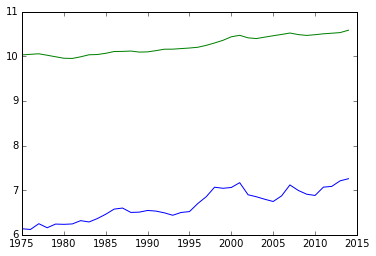

In [19]:
plt.plot(df['year'],df['log_rent'])
plt.plot(df['year'],df['log_wages'])
plt.ylim=(0,100)

In [20]:
X=df[['const','log_wages1','log_units','log_employment']]
y=df['log_rent']
model=sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_rent   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     233.7
Date:                Fri, 20 May 2016   Prob (F-statistic):           1.20e-23
Time:                        07:07:16   Log-Likelihood:                 47.410
No. Observations:                  40   AIC:                            -86.82
Df Residuals:                      36   BIC:                            -80.06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const             -2.0768      8.894     -0.233      0.817       -20.115    15.961
log_wages1         1.8729      0.209      8.945      0.000         1.448     2.298
log_units         -2.4115      0.916     -2.632      0.012        -4.269    -0.553
log_employment    -0.3361      0.243     -1.382      0.176        -0.829     0.157
==============================================================================
Omnibus:                        8.262   Durbin-Watson:                   1.268
Prob(Omnibus):                  0.016   Jarque-Bera (JB):                7.753
Skew:                           0.747   Prob(JB):                       0.0207
Kurtosis:                       4.556   Cond. No.                     2.16e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

So what I did was replicate the analysis, sort of, from Eric Fisher. We got a very high R2, like he did, and we got similar coefficients, but they are on the wrong variables, maybe he just typoed at this point, or maybe the numerical solver he used is slightly different since I used a closed form solution and he probably used gradient descent or something. At the very least we have some cause for concern over his methodology at this point. Let's do some ADF tests, and then some differencing, and then some regressions like we did for our monte carlo problem.

In [27]:
print adfuller(df['log_wages1'],regression='ct')
print adfuller(df['log_units'],regression='ct')
print adfuller(df['log_employment'],regression='ct')
print adfuller(df['log_rent'],regression='ct')

(-3.7366859898264839, 0.02005222001726395, 7L, 32L, {'5%': -3.5578989233398435, '1%': -4.2735351794433596, '10%': -3.2123659912109375}, -109.22681279637681)
(-0.12946684697940328, 0.99265733003382928, 7L, 32L, {'5%': -3.5578989233398435, '1%': -4.2735351794433596, '10%': -3.2123659912109375}, -279.4738300490597)
(-3.9071272117414075, 0.0118618577709816, 1L, 38L, {'5%': -3.5331113660883506, '1%': -4.219141325995043, '10%': -3.1982181075958596}, -133.32580782185863)
(-2.9246868949902911, 0.15436760022652568, 1L, 38L, {'5%': -3.5331113660883506, '1%': -4.219141325995043, '10%': -3.1982181075958596}, -44.763144576785095)


Although log rent and log units appear to be stationary, log rent is close enough that I kind of doubt it. Let's see if it is with a slightly longer time series. If not, we'lll difference that one too.

In [31]:
df2=pandas.read_csv('c:/users/ryan/desktop/combined.csv')
df2['log_rent']=np.log(df2['median_rent'])-np.log(df2['CPI'])
df2['log_units']=np.log(df2['housing_units'])
print adfuller(df2['log_rent'].dropna(),regression='ct')
print adfuller(df2['log_units'].dropna(),regression='ct')

(-5.2757100927634326, 6.289888491507311e-05, 2L, 66L, {'5%': -3.4792434170910203, '1%': -4.1029309851963154, '10%': -3.1672046581517659}, -114.59663628236939)
(-6.4499403612739741, 2.3759010171895862e-07, 13L, 95L, {'5%': -3.4577588776789616, '1%': -4.0573721781600813, '10%': -3.1547278480828109}, -827.78931224872804)


Okay the other two that we thought might be stationary really aren't stationary. We just didn't have enough data to detect that it wasn't before, probably because of greater variability than say log_wages. Let's take first differences of all of these variables and then run a regression.

In [32]:
df['wages_']=df['log_wages1'].diff(1)
df['units_']=df['log_units'].diff(1)
df['emp_']=df['log_employment'].diff(1)
df['rent_']=df['log_rent'].diff(1)
X=df[['const','wages_','units_','emp_']].dropna()
y=df['rent_'].dropna()
model=sm.OLS(y,X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  rent_   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     6.775
Date:                Fri, 20 May 2016   Prob (F-statistic):            0.00101
Time:                        07:31:02   Log-Likelihood:                 42.801
No. Observations:                  39   AIC:                            -77.60
Df Residuals:                      35   BIC:                            -70.95
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0315      0.033      0.967      0.340        -0.035     0.098
wages_         1.5855      0.479      3.310      0.002         0.613     2.558
units_        -7.9982      6.335     -1.263      0.215       -20.859     4.863
emp_          -0.6667      0.615     -1.084      0.286        -1.915     0.582
==============================================================================
Omnibus:                        0.930   Durbin-Watson:                   2.588
Prob(Omnibus):                  0.628   Jarque-Bera (JB):                0.818
Skew:                           0.004   Prob(JB):                        0.664
Kurtosis:                       2.291   Cond. No.                         464.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's interpret that. It looks like what is driving the increase in rents is an increase in income. A 1% shock to wages leads to a 1.583% increase to the shock of rents. Number of units and number of people employed do not have a statistically  significant effect. And on top of that there is not a statisitically significant independent trend for rents. In other words, the increase in rent is being driven solely by the increasing in wages.

So can I reasonably say that if everybody took a pay cut we could reduce rents? I don't think so. There is more that I see wrong here, but I will leave that until I have more time to write a more thourough blog post at [barnesanalytics.com](http://www.barnesanalytics.com)